# Linear regression in `numpyro`

Let's see an initial demonstration of *gradient based inference* using the *probabilistic programming language* `numpyro`.

To run this notebook you will need to install:
- [numpyro](https://num.pyro.ai/en/latest/getting_started.html#installation)
- [arviz](https://python.arviz.org/en/stable/getting_started/Installation.html)

in addition to standard libraries: `numpy`, `scipy`, `matplotlib`.

This notebook demonstrates linear regression in numpyro.

In [1]:
import numpy as np
np.random.seed(301288)
from scipy import stats
import matplotlib.pyplot as plt

## Generate some mock data

Let's make some mock data for linear regression. 

We'll take some gradient $m$, and slope $c$, and generate 

$$
y_j = m x_j + c
$$

The following function generates this mock data:

In [2]:
def get_data(m = 0.5,
             c = -1.,
             sig_y = 0.5,
             n_dat = 100):
    '''generate mock data for linear regression according to model y = mx + c
    For j = 1, ..., n_dat:
        x_j ~ Unif(-3, 3) 
        y^{obs}_j ~ Norm(m * x_j + c, sig_y)
    
    ''' 
    unif_x = stats.uniform(loc=-3, scale=6)
    x = unif_x.rvs(n_dat)
    nrm_y_obs = stats.norm(m*x+c, sig_y)
    y_obs = nrm_y_obs.rvs()
    true_pars = {
        'm':m,
        'c':c
    }
    data = {'n_dat':n_dat, 'x':x, 'y_obs':y_obs, 'sig_y':sig_y}
    return true_pars, data

In [3]:
def plot_data(data, samples=None):
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    ax.plot(data['x'], data['y_obs'], '.', zorder=np.inf)
    ax.axhline(0, ls='--', color='k', alpha=0.2)
    ax.axvline(0, ls='--', color='k', alpha=0.2)
    if samples is not None:
        x = np.linspace(-3,3,100)
        y_smp = samples['m']*x[:,np.newaxis] + samples['c']
        y_lo, y_hi = np.percentile(y_smp, [0.5,99.5], 1)
        ax.fill_between(x, y_lo, y_hi, color='C1', alpha=0.5)
        # draw a selection of samples
        n_samples_to_draw = 30
        for i in np.random.choice(samples['m'].shape[0], n_samples_to_draw):
            m0, c0 = samples['m'][i], samples['c'][i]
            ax.plot(x, m0*x + c0, color='C1', alpha=0.5)
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    return fig

## Look at the data

In [4]:
true_pars, data = get_data()

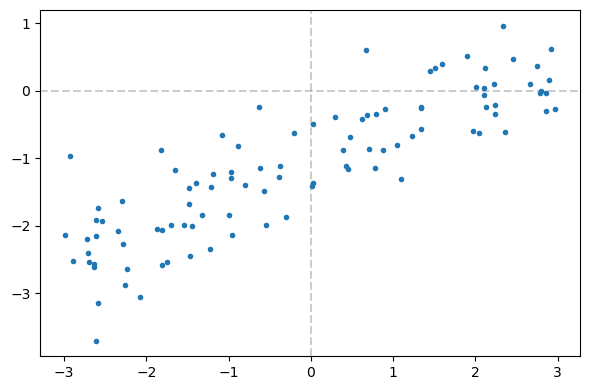

In [5]:
_ = plot_data(data)

## Define a probabilistic model in `numpyro` to fit this data

In [6]:
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

/Users/yhra/miniconda3/envs/BATIP/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
def model(data):
    # define priors on m, c
    prior_m = dist.Normal(0, 3)
    prior_c = dist.Normal(0, 3)
    # sample m and c from the priors
    m = numpyro.sample('m', prior_m)
    c = numpyro.sample('c', prior_c)
    # sample observed data
    with numpyro.plate('n_dat', data['n_dat']):
        # sample the data
        y_obs = numpyro.sample(
            'y_obs', 
            dist.Normal(m*data['x']+c, data['sig_y']),
            obs=data['y_obs'])
    return

## Draw the Bayesian Network for this model

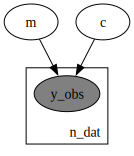

In [8]:
numpyro.render_model(model,  model_args=(data,))

## Run NUTS

This is a *gradient-based inference algorithm* for MCMC sampling.

In [9]:
# Start from this source of randomness
rng_key = random.PRNGKey(0)

# Run NUTS.
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=500, num_samples=1000)
mcmc.run(rng_key, data)

sample: 100%|██████████| 1500/1500 [00:00<00:00, 2499.62it/s, 7 steps of size 7.89e-01. acc. prob=0.93]


In [10]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         c     -1.05      0.05     -1.05     -1.14     -0.97    580.73      1.00
         m      0.48      0.03      0.48      0.43      0.52    909.60      1.00

Number of divergences: 0


In [11]:
mcmc.get_samples()['m'].shape

(1000,)

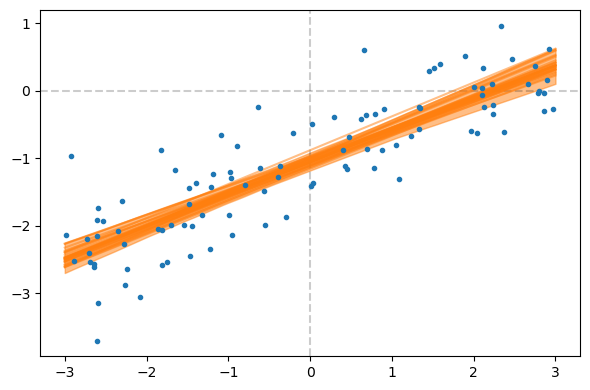

In [12]:
_ = plot_data(data, samples=mcmc.get_samples())

## Look at the posterior samples

In [13]:
import arviz as az

In [14]:
az_mcmc = az.from_numpyro(mcmc)

In [15]:
az_mcmc

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

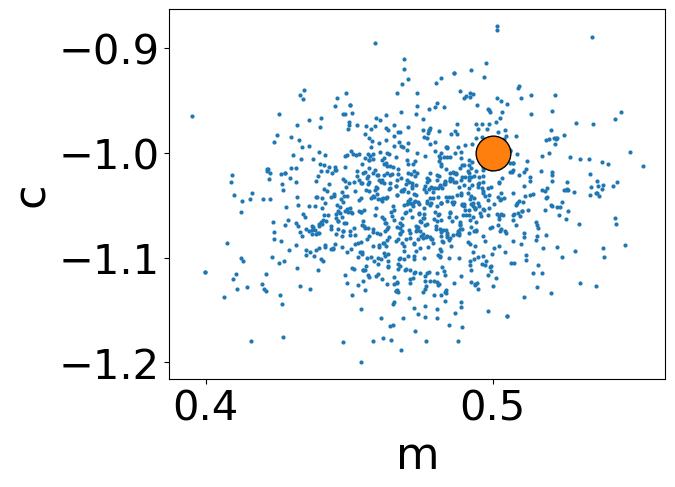

In [16]:
_ = az.plot_pair(
    az_mcmc,
    var_names=['m', 'c'],
    reference_values=true_pars,
    reference_values_kwargs={'color':'C1', 'markersize':25},
    textsize=30)

The true values (orange) lie within the posterior samples (blue) - i.e. the inference has succeessfully estimates the truth.

The with of the posterior gives us an estimate of the uncertainty in our inference.